# Real-Space Orbital Visualization

This notebook demonstrates pysktb's orbital visualization capabilities, enabling real-space visualization of atomic orbitals and charge densities from tight-binding calculations.

**Features:**
- Slater-type, Gaussian, and Hydrogen-like radial functions
- Real spherical harmonics for angular parts (s, p, d, f orbitals)
- 2D slice plots with customizable planes
- 3D isosurface visualization
- Edge state wavefunction visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append("../../../")

from pysktb import (
    Structure, Atom, Lattice, Hamiltonian,
    SlaterOrbital, HydrogenOrbital, GaussianOrbital,
    OrbitalBasis, OrbitalPlotter,
    # Ribbon visualization helpers
    plot_ribbon_edge_state, plot_edge_vs_bulk_comparison,
    tile_supercell, get_nearest_neighbor_bonds, draw_bonds
)

# Beautiful plot style
plt.style.use('default')
mpl.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'figure.figsize': (10, 8),
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Color palette
COLORS = {
    'primary': '#2563eb',
    'secondary': '#dc2626', 
    'accent': '#059669',
    'purple': '#7c3aed',
}

## Radial Functions

pysktb provides three types of radial functions:

1. **Slater-type orbitals (STO)**: $R(r) = N r^{n-1} e^{-\zeta r}$
2. **Hydrogen-like orbitals**: $R_{nl}(r) = N \rho^l e^{-\rho/2} L_{n-l-1}^{2l+1}(\rho)$
3. **Gaussian-type orbitals (GTO)**: $R(r) = N r^l e^{-\alpha r^2}$

The Slater exponent $\zeta$ controls orbital size: larger $\zeta$ = more compact orbital.

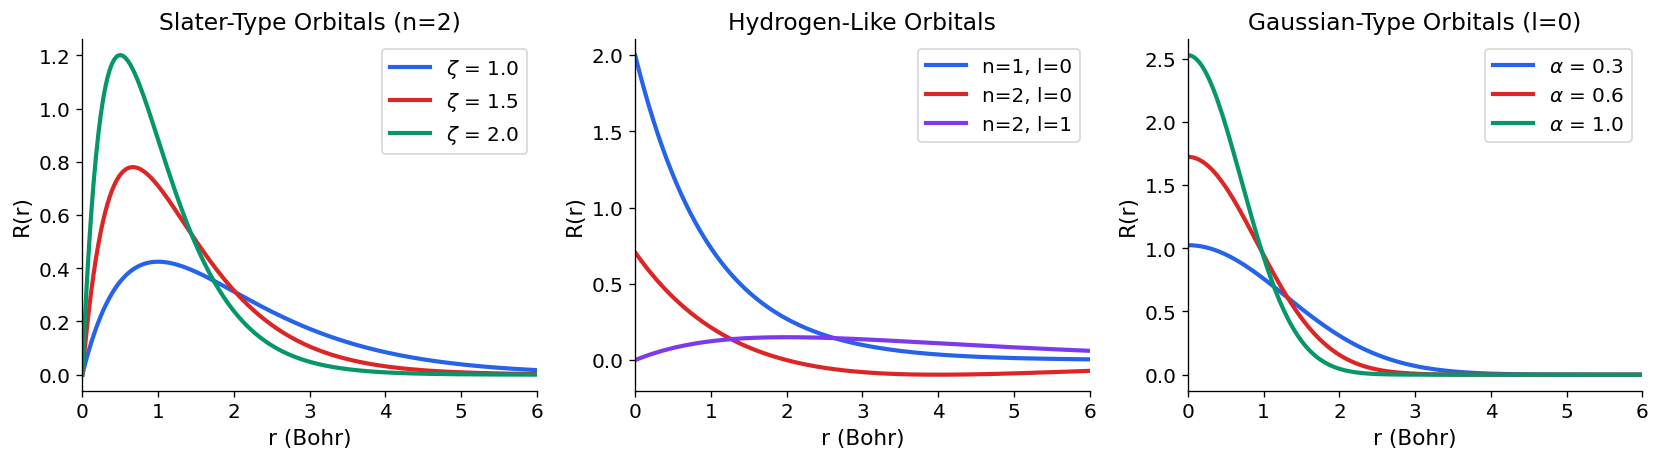

In [2]:
# Compare radial function types
r = np.linspace(0, 6, 200)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Slater orbitals with different zeta
ax = axes[0]
for zeta, color in zip([1.0, 1.5, 2.0], [COLORS['primary'], COLORS['secondary'], COLORS['accent']]):
    sto = SlaterOrbital(n=2, zeta=zeta)
    ax.plot(r, sto(r), color=color, lw=2.5, label=f'$\\zeta$ = {zeta}')
ax.set_xlabel('r (Bohr)')
ax.set_ylabel('R(r)')
ax.set_title('Slater-Type Orbitals (n=2)')
ax.legend(frameon=True, fancybox=True)
ax.set_xlim(0, 6)

# Hydrogen-like orbitals
ax = axes[1]
for (n, l), color in zip([(1, 0), (2, 0), (2, 1)], [COLORS['primary'], COLORS['secondary'], COLORS['purple']]):
    hyd = HydrogenOrbital(n=n, l=l, Z=1.0)
    ax.plot(r, hyd(r), color=color, lw=2.5, label=f'n={n}, l={l}')
ax.set_xlabel('r (Bohr)')
ax.set_ylabel('R(r)')
ax.set_title('Hydrogen-Like Orbitals')
ax.legend(frameon=True, fancybox=True)
ax.set_xlim(0, 6)

# Gaussian orbitals
ax = axes[2]
for alpha, color in zip([0.3, 0.6, 1.0], [COLORS['primary'], COLORS['secondary'], COLORS['accent']]):
    gto = GaussianOrbital(l=0, alpha=alpha)
    ax.plot(r, gto(r), color=color, lw=2.5, label=f'$\\alpha$ = {alpha}')
ax.set_xlabel('r (Bohr)')
ax.set_ylabel('R(r)')
ax.set_title('Gaussian-Type Orbitals (l=0)')
ax.legend(frameon=True, fancybox=True)
ax.set_xlim(0, 6)

plt.tight_layout()
plt.savefig('data/radial_functions.png', dpi=150, bbox_inches='tight')
plt.show()

## Atomic Orbital Visualization

Complete atomic orbitals combine radial functions with real spherical harmonics:

$$\phi(r, \theta, \varphi) = R(r) \cdot Y_l^m(\theta, \varphi)$$

The angular part gives the characteristic orbital shapes:
- **s orbitals**: Spherically symmetric
- **p orbitals**: Dumbbell shapes along x, y, z
- **d orbitals**: Cloverleaf and other shapes

In [3]:
def create_single_atom(element='C', orbitals=['s', 'px', 'py', 'pz']):
    """Create a simple structure with one atom."""
    lattice = Lattice([[1, 0, 0], [0, 1, 0], [0, 0, 1]], 10.0)
    atom = Atom(element, [0.5, 0.5, 0.5], orbitals=orbitals)
    bond_cut = {f'{element}{element}': {'NN': 5.0}}
    structure = Structure(lattice, [atom], bond_cut=bond_cut,
                         periodicity=[False, False, False])
    return structure

# Create structure and orbital basis
structure = create_single_atom('C', ['s', 'px', 'py', 'pz'])
basis = OrbitalBasis(structure, {
    'C': {
        's': SlaterOrbital(n=2, zeta=1.57),
        'px': SlaterOrbital(n=2, zeta=1.57),
        'py': SlaterOrbital(n=2, zeta=1.57),
        'pz': SlaterOrbital(n=2, zeta=1.57),
    }
})
plotter = OrbitalPlotter.from_structure(structure, basis)

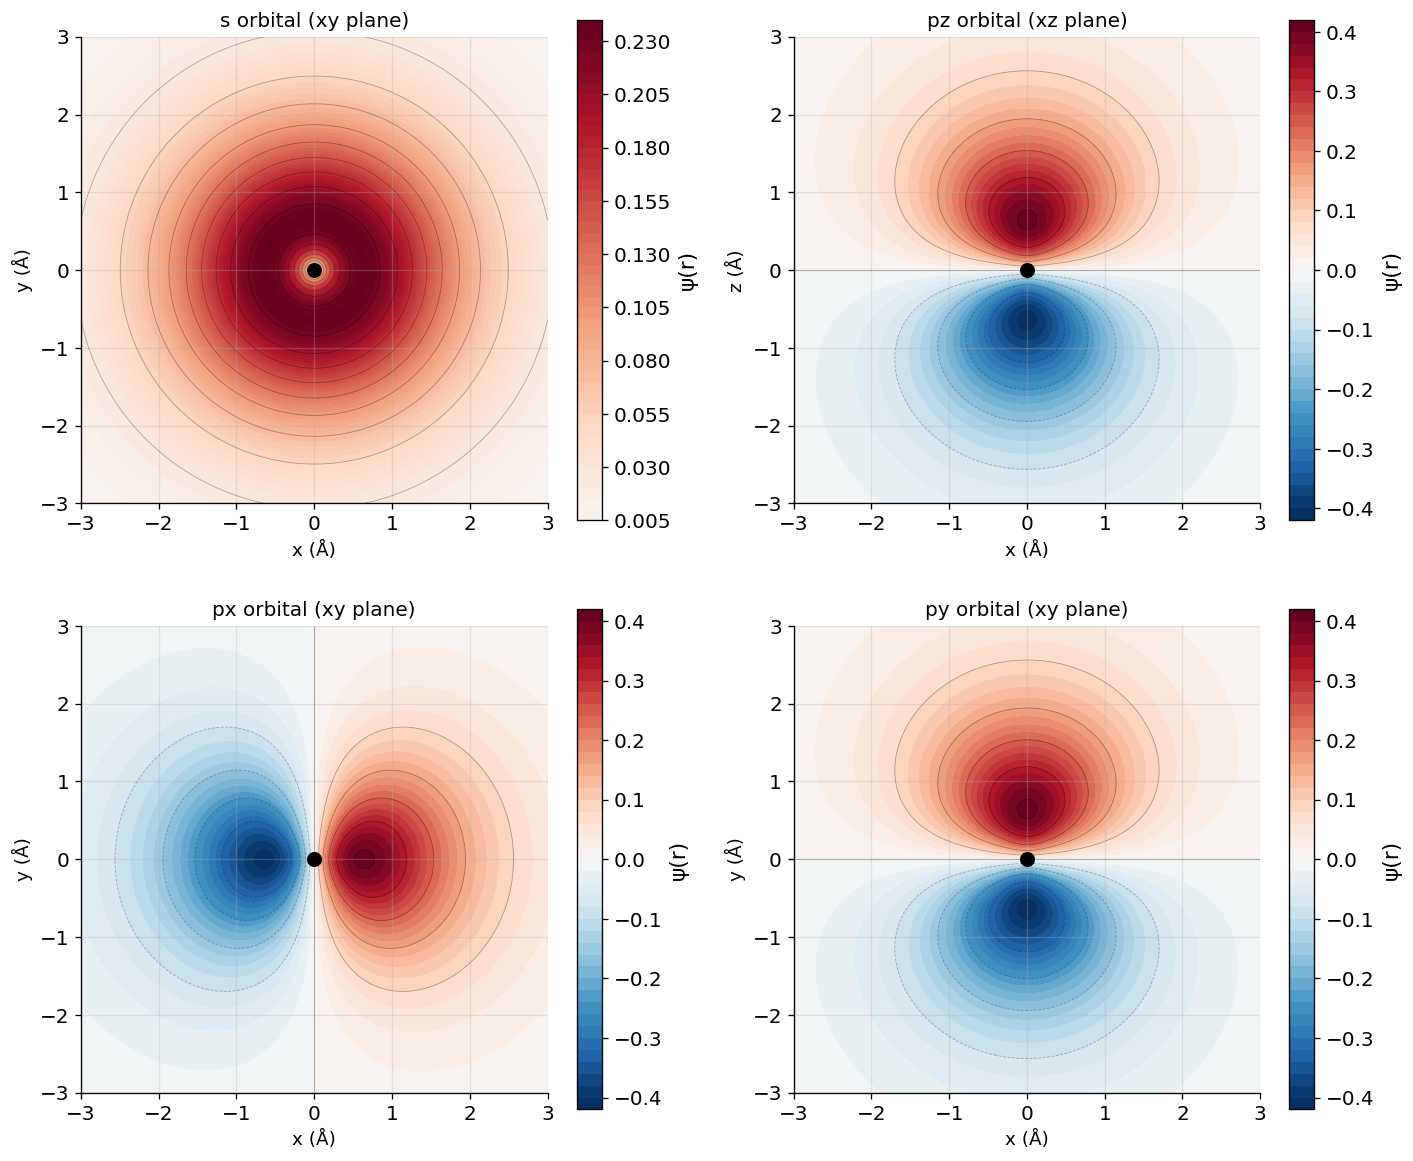

In [4]:
# Gallery of atomic orbitals
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

orbitals_to_plot = [
    ('s', 'xy', 's orbital (xy plane)'),
    ('pz', 'xz', 'pz orbital (xz plane)'),
    ('px', 'xy', 'px orbital (xy plane)'),
    ('py', 'xy', 'py orbital (xy plane)'),
]

for ax, (orb, plane, title) in zip(axes.flatten(), orbitals_to_plot):
    plotter.plot_orbital_2d(atom_idx=0, orbital=orb, plane=plane,
                            extent=3.0, resolution=100, ax=ax, title=title)

plt.tight_layout()
plt.savefig('data/atomic_orbitals_gallery.png', dpi=150, bbox_inches='tight')
plt.show()

## Effect of Slater Exponent ($\zeta$)

The Slater exponent controls orbital localization:
- **Large $\zeta$**: Compact, tightly bound orbital
- **Small $\zeta$**: Diffuse, spread out orbital

Default values from Clementi-Raimondi (1963) tables are built into pysktb.

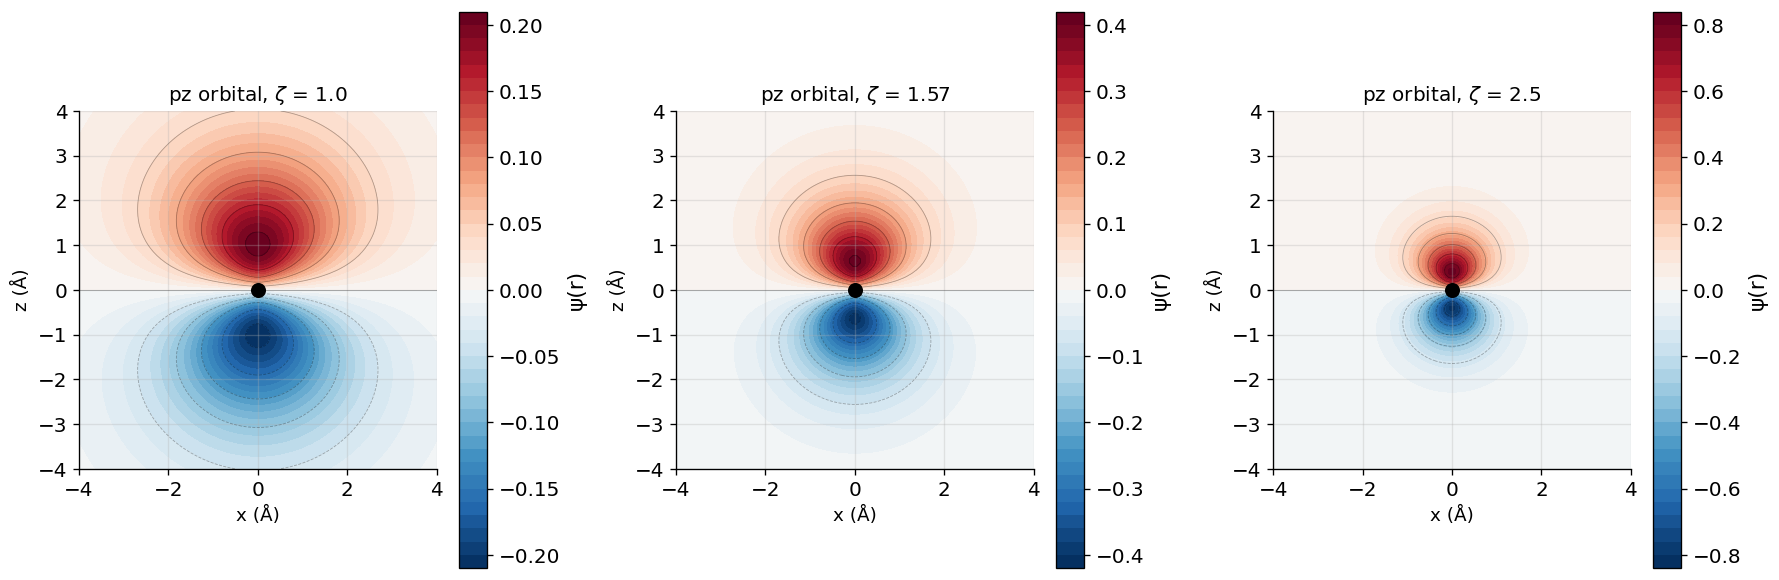

In [5]:
# Compare orbital size for different Slater exponents
zetas = [1.0, 1.57, 2.5]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, zeta in zip(axes, zetas):
    structure = create_single_atom('C', ['pz'])
    basis = OrbitalBasis(structure, {
        'C': {'pz': SlaterOrbital(n=2, zeta=zeta)}
    })
    plotter = OrbitalPlotter.from_structure(structure, basis)
    
    plotter.plot_orbital_2d(atom_idx=0, orbital='pz', plane='xz',
                            extent=4.0, resolution=100, ax=ax,
                            title=f'pz orbital, $\\zeta$ = {zeta}')

plt.tight_layout()
plt.savefig('data/slater_exponent_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Graphene Orbital Visualization

Graphene's electronic properties arise from overlapping pz orbitals forming the $\pi$ band.
Here we visualize the pz orbitals at different heights above the graphene plane.

In [6]:
def create_graphene():
    """Create graphene structure with pz orbitals."""
    a = 2.46  # Lattice constant
    lattice_matrix = [[1, 0, 0],
                      [0.5, np.sqrt(3)/2, 0],
                      [0, 0, 10]]
    lattice = Lattice(lattice_matrix, a)
    
    atom_A = Atom('C', [0, 0, 0.5], orbitals=['pz'])
    atom_B = Atom('C', [1/3, 1/3, 0.5], orbitals=['pz'])
    
    d_nn = a / np.sqrt(3)
    bond_cut = {'CC': {'NN': d_nn * 1.1}}
    
    structure = Structure(
        lattice, [atom_A, atom_B],
        periodicity=[True, True, False],
        bond_cut=bond_cut
    )
    return structure

graphene = create_graphene()
basis = OrbitalBasis(graphene, {'C': {'pz': SlaterOrbital(n=2, zeta=1.57)}})
params = {'C': {'e_p': 0.0}, 'CC': {'V_ppp': -2.7}}
ham = Hamiltonian(graphene, params, numba=0)
plotter = OrbitalPlotter(ham, basis)

print(f'Graphene unit cell: {len(graphene.atoms)} atoms')

Graphene unit cell: 2 atoms


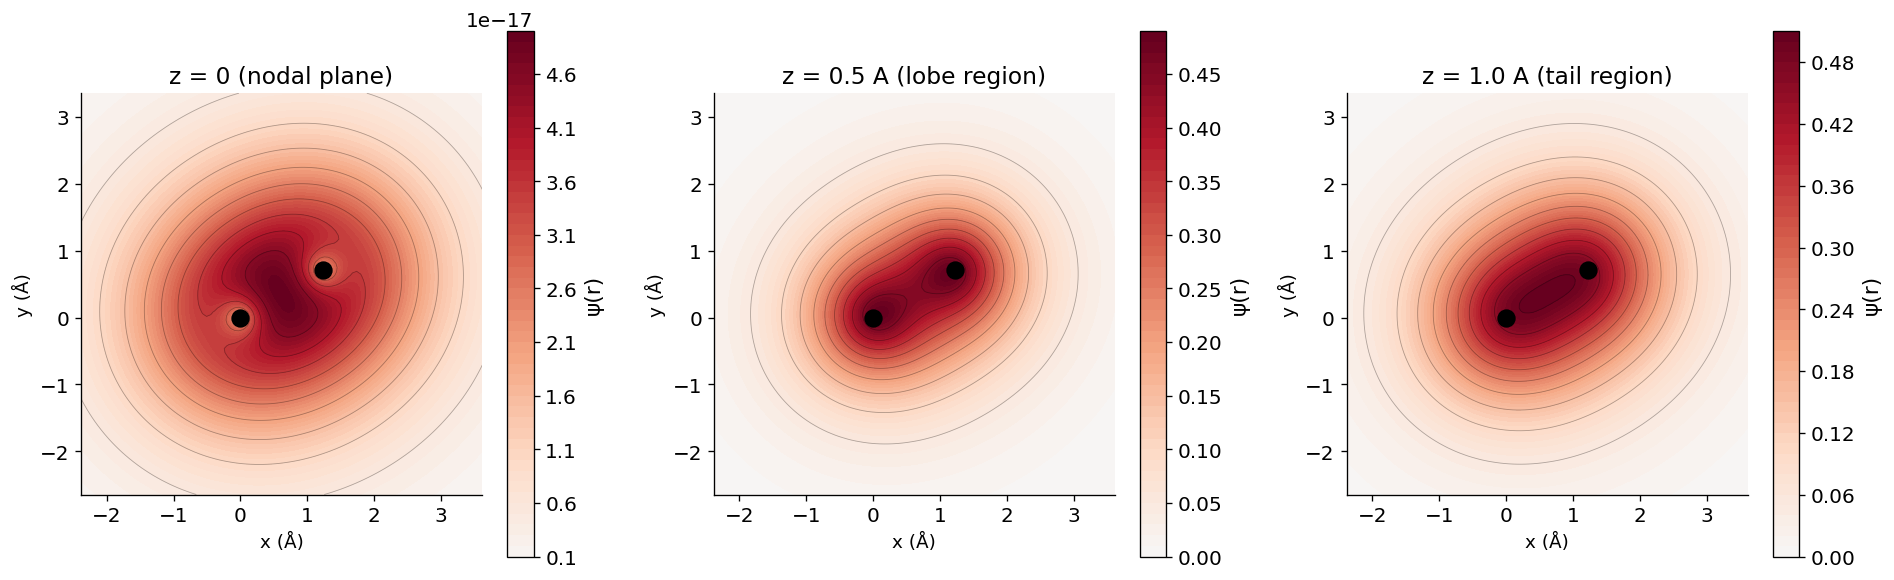

In [7]:
# Graphene pz orbitals at different heights
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

heights = [0.0, 0.5, 1.0]
titles = [
    'z = 0 (nodal plane)',
    'z = 0.5 A (lobe region)',
    'z = 1.0 A (tail region)'
]

for ax, z, title in zip(axes, heights, titles):
    plotter.plot_structure_orbitals_2d(plane='xy', slice_value=z,
                                       extent=3.0, resolution=100, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.savefig('data/graphene_pz_heights.png', dpi=150, bbox_inches='tight')
plt.show()

## 3D Orbital Visualization

Visualize the full 3D shape of atomic orbitals using scatter plots weighted by probability density.

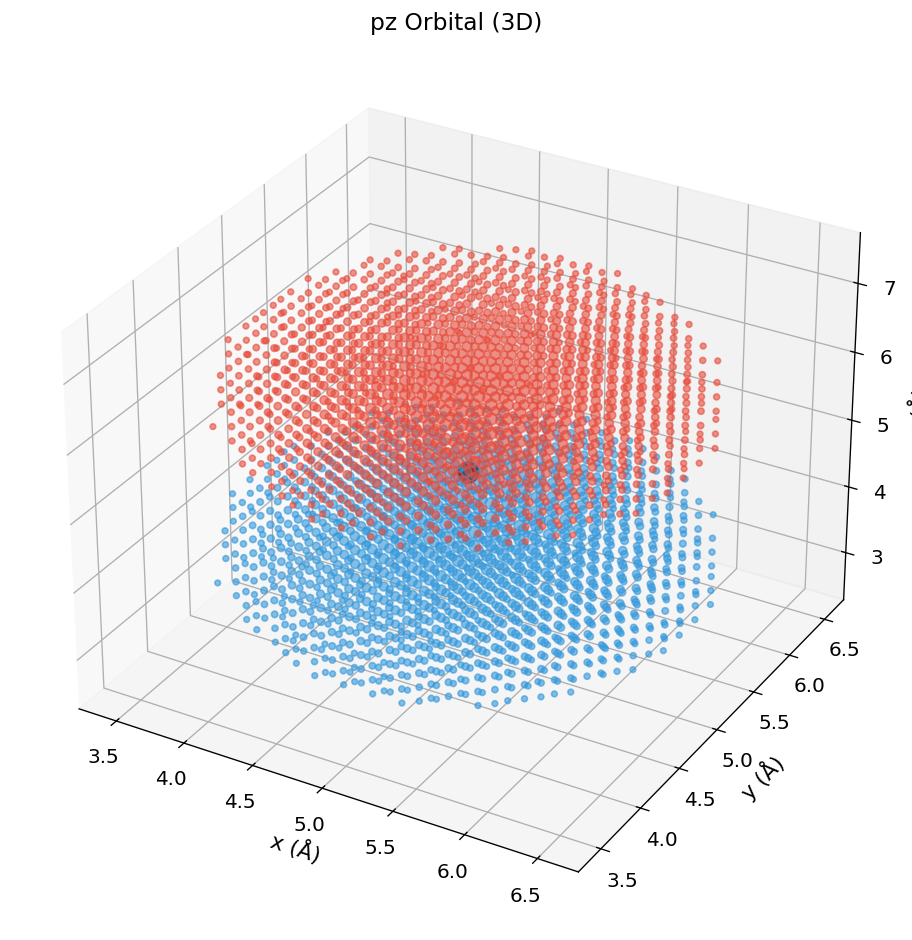

In [8]:
# 3D visualization of pz orbital
structure = create_single_atom('C', ['pz'])
basis = OrbitalBasis(structure, {'C': {'pz': SlaterOrbital(n=2, zeta=1.57)}})
plotter = OrbitalPlotter.from_structure(structure, basis)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plotter.plot_orbital_3d_simple(atom_idx=0, orbital='pz',
                               extent=3.0, resolution=30,
                               n_points=3000, ax=ax)
ax.set_title('pz Orbital (3D)', fontsize=14)
plt.tight_layout()
plt.savefig('data/pz_orbital_3d.png', dpi=150, bbox_inches='tight')
plt.show()

## Edge State Visualization

Topological edge states in graphene zigzag ribbons are localized at the ribbon edges.
Here we visualize the real-space probability distribution of edge states vs bulk states.

In [9]:
def create_zigzag_ribbon(n_chains=8):
    """Create a graphene zigzag nanoribbon."""
    a = 2.46
    d_cc = a / np.sqrt(3)
    vacuum = 6.0
    ribbon_height = n_chains * a * np.sqrt(3) / 2
    total_height = ribbon_height + vacuum
    
    lattice = Lattice([[1, 0, 0], [0, total_height/a, 0], [0, 0, vacuum/a]], a)
    
    A_base, B_base = np.array([0.0, 0.0]), np.array([a/2, a*np.sqrt(3)/6])
    shift = np.array([a/2, a*np.sqrt(3)/2])
    
    atoms, edge_atoms = [], []
    for i in range(n_chains):
        A_cart = A_base + i * shift
        A_cart[0] = A_cart[0] % a
        B_cart = B_base + i * shift
        B_cart[0] = B_cart[0] % a
        
        atoms.append(Atom('C', [A_cart[0]/a, A_cart[1]/total_height, 0.5], orbitals=['pz']))
        atoms.append(Atom('C', [B_cart[0]/a, B_cart[1]/total_height, 0.5], orbitals=['pz']))
        
        if i == 0 or i == n_chains - 1:
            edge_atoms.extend([len(atoms)-2, len(atoms)-1])
    
    bond_cut = {'CC': {'NN': d_cc * 1.1}}
    structure = Structure(lattice, atoms, periodicity=[True, False, False], bond_cut=bond_cut)
    return structure, edge_atoms

# Create a WIDER ribbon to better show edge localization
n_chains = 16  # Larger ribbon
ribbon, edge_atoms = create_zigzag_ribbon(n_chains=n_chains)
params = {'C': {'e_p': 0.0}, 'CC': {'V_ppp': -2.7}}
ham_ribbon = Hamiltonian(ribbon, params, numba=False)

print(f'Ribbon: {len(ribbon.atoms)} atoms ({n_chains} zigzag chains)')
print(f'Edge atoms (top & bottom): {edge_atoms}')

Ribbon: 32 atoms (16 zigzag chains)
Edge atoms (top & bottom): [0, 1, 30, 31]


In [10]:
# Compute eigenstates at k in flat band region (k=0.5 is center of flat band)
eigenvalues, eigenvectors = ham_ribbon.solve_kpath([[0.5, 0.0, 0.0]], 
                                                    eig_vectors=True, 
                                                    soc=False, parallel=0)
eigenvalues = eigenvalues[:, 0]
eigenvectors = eigenvectors[:, 0, :]

# Find edge states (states closest to E=0) and bulk state (furthest from E=0)
energies = eigenvalues.real
sorted_idx = np.argsort(np.abs(energies))

# Sum over the two lowest-energy states (both edge states) to show both edges
edge_idx1 = sorted_idx[0]
edge_idx2 = sorted_idx[1]
bulk_idx = sorted_idx[-1]

edge_state1 = eigenvectors[edge_idx1, :]
edge_state2 = eigenvectors[edge_idx2, :]
bulk_state = eigenvectors[bulk_idx, :]

# Combine both edge states to show charge at BOTH edges
edge_prob = np.abs(edge_state1) ** 2 + np.abs(edge_state2) ** 2
bulk_prob = np.abs(bulk_state) ** 2

# Normalize
edge_prob = edge_prob / edge_prob.max()
bulk_prob = bulk_prob / bulk_prob.max()

# Get atom positions
positions = []
for atom in ribbon.atoms:
    frac_pos = np.array(atom.pos)
    cart_pos = np.dot(frac_pos, ribbon.lattice.matrix)
    positions.append(cart_pos)
positions = np.array(positions)

print(f'Edge state 1 energy: {energies[edge_idx1]:.4f} eV')
print(f'Edge state 2 energy: {energies[edge_idx2]:.4f} eV')
print(f'Bulk state energy: {energies[bulk_idx]:.3f} eV')

2
Edge state 1 energy: -0.0000 eV
Edge state 2 energy: -0.0000 eV
Bulk state energy: 2.700 eV


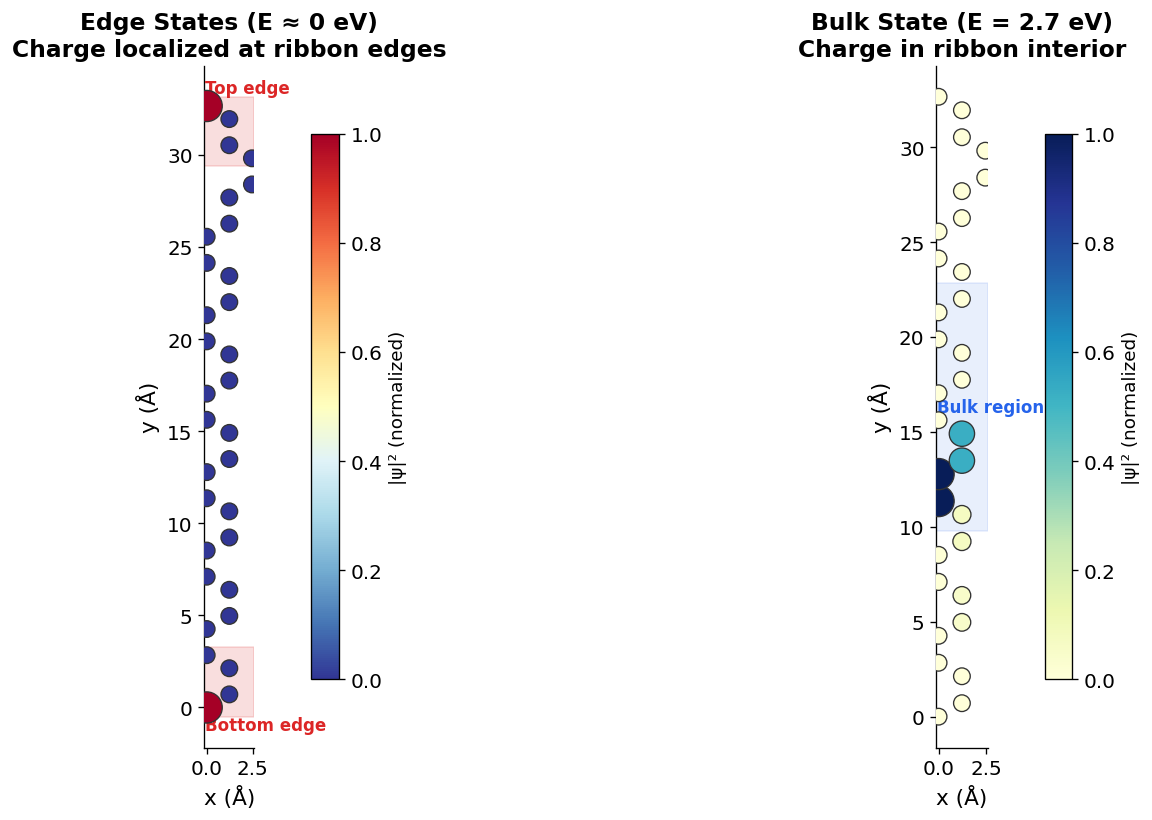

\n✓ Edge states show exponential decay from ribbon edges
✓ Bulk states have maximum in ribbon interior
✓ This is characteristic of topological edge states in zigzag graphene!


In [11]:
# Beautiful edge state visualization - README quality
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Compute y positions for edge highlighting
y_pos = positions[:, 1]
y_min, y_max = y_pos.min(), y_pos.max()
is_bottom_edge = y_pos < (y_min + 0.1 * (y_max - y_min))
is_top_edge = y_pos > (y_max - 0.1 * (y_max - y_min))

# Edge state plot
ax = axes[0]
scatter = ax.scatter(positions[:, 0], positions[:, 1],
                     c=edge_prob, s=250 * edge_prob + 100,
                     cmap='RdYlBu_r', edgecolors='#333', linewidths=0.8,
                     vmin=0, vmax=1, zorder=5)

# Add edge highlighting boxes
ax.axhspan(y_min - 0.5, y_min + 0.1*(y_max-y_min), 
           alpha=0.15, color=COLORS['secondary'], zorder=1)
ax.axhspan(y_max - 0.1*(y_max-y_min), y_max + 0.5, 
           alpha=0.15, color=COLORS['secondary'], zorder=1)

ax.set_xlabel('x (Å)', fontsize=13)
ax.set_ylabel('y (Å)', fontsize=13)
ax.set_title(f'Edge States (E ≈ 0 eV)\nCharge localized at ribbon edges',
             fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('|ψ|² (normalized)', fontsize=11)
ax.set_aspect('equal')
ax.text(0.02, 0.98, 'Top edge', transform=ax.transAxes, fontsize=10, 
        va='top', color=COLORS['secondary'], fontweight='bold')
ax.text(0.02, 0.02, 'Bottom edge', transform=ax.transAxes, fontsize=10,
        va='bottom', color=COLORS['secondary'], fontweight='bold')

# Bulk state plot
ax = axes[1]
scatter = ax.scatter(positions[:, 0], positions[:, 1],
                     c=bulk_prob, s=250 * bulk_prob + 100,
                     cmap='YlGnBu', edgecolors='#333', linewidths=0.8,
                     vmin=0, vmax=1, zorder=5)

# Add "bulk region" highlighting
ax.axhspan(y_min + 0.3*(y_max-y_min), y_max - 0.3*(y_max-y_min), 
           alpha=0.1, color=COLORS['primary'], zorder=1)

ax.set_xlabel('x (Å)', fontsize=13)
ax.set_ylabel('y (Å)', fontsize=13)
ax.set_title(f'Bulk State (E = {energies[bulk_idx]:.1f} eV)\nCharge in ribbon interior',
             fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('|ψ|² (normalized)', fontsize=11)
ax.set_aspect('equal')
ax.text(0.02, 0.5, 'Bulk region', transform=ax.transAxes, fontsize=10,
        va='center', color=COLORS['primary'], fontweight='bold')

plt.tight_layout()
plt.savefig('data/edge_vs_bulk_states.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print('\\n✓ Edge states show exponential decay from ribbon edges')
print('✓ Bulk states have maximum in ribbon interior')
print('✓ This is characteristic of topological edge states in zigzag graphene!')

## Enhanced Edge State Visualization: Superlattice View

To better visualize the honeycomb structure and edge localization, we tile multiple unit cells 
along the periodic direction and explicitly draw the bonds between atoms.

This shows:
- **Honeycomb lattice** with visible C-C bonds
- **Multiple unit cells** (superlattice) along the zigzag direction
- **Probability density** via circle size and color

In [ ]:
# Extract 2D positions and lattice vector for tiling
positions_2d = positions[:, :2]  # x, y coordinates
lattice_vec = np.array([ribbon.lattice.matrix[0, 0], 0])  # x-direction periodicity

# Create superlattice view with bonds - EDGE STATE
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Edge state with honeycomb bonds
ax = axes[0]
edge_amplitudes = np.sqrt(edge_prob)  # Use sqrt for better visual scaling

plot_ribbon_edge_state(positions_2d, edge_amplitudes, 
                       lattice_vector=lattice_vec, n_cells=5,
                       bond_cutoff=1.5, show_bonds=True,
                       ax=ax, title='Edge State - Honeycomb Superlattice',
                       cmap='hot')
ax.text(0.02, 0.98, 'Charge at ribbon edges', transform=ax.transAxes,
        fontsize=11, va='top', color='white', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

# Bulk state with honeycomb bonds
ax = axes[1]
bulk_amplitudes = np.sqrt(bulk_prob)

plot_ribbon_edge_state(positions_2d, bulk_amplitudes,
                       lattice_vector=lattice_vec, n_cells=5,
                       bond_cutoff=1.5, show_bonds=True,
                       ax=ax, title='Bulk State - Honeycomb Superlattice',
                       cmap='viridis')
ax.text(0.02, 0.98, 'Charge in bulk', transform=ax.transAxes,
        fontsize=11, va='top', color='white', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.savefig('data/edge_state_superlattice.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print('\n✓ Honeycomb structure clearly visible with bonds')
print('✓ Multiple unit cells show extended ribbon structure')
print('✓ Edge state charge concentrated at top and bottom edges')

## Edge State with pz Orbital Lobes

For an even more physical visualization, we can draw stylized pz orbital lobes at each atom
position, with the lobe size proportional to the wavefunction amplitude.

In [ ]:
# Edge state with pz orbital lobes
fig, ax = plt.subplots(figsize=(14, 10))

# Use fewer cells for clarity with lobes
plot_ribbon_edge_state(positions_2d, edge_amplitudes,
                       lattice_vector=lattice_vec, n_cells=4,
                       bond_cutoff=1.5, show_bonds=True,
                       show_lobes=True,  # Enable pz orbital lobes!
                       ax=ax, title='Edge State with pz Orbital Lobes',
                       cmap='Oranges')

ax.text(0.02, 0.98, 
        'Red/Blue ellipses = pz lobes\nSize ∝ |ψ|²', 
        transform=ax.transAxes, fontsize=11, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig('data/edge_state_pz_lobes.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print('\n✓ pz orbital lobes shown as ellipses above/below plane')
print('✓ Larger lobes at edges = higher probability density')
print('✓ This represents how pz orbitals stick out of the graphene plane')

## Summary

pysktb's orbital visualization module provides:

1. **Radial Functions**: SlaterOrbital, HydrogenOrbital, GaussianOrbital with built-in normalization
2. **Spherical Harmonics**: Real-valued for all s, p, d, f orbitals
3. **2D Visualization**: Customizable plane slices (xy, xz, yz)
4. **3D Visualization**: Probability-weighted scatter plots
5. **Edge States**: Combine eigenvector analysis with real-space orbital visualization
6. **Superlattice View**: Multi-cell tiling with honeycomb bonds for ribbon structures
7. **pz Orbital Lobes**: Stylized orbital visualization weighted by wavefunction amplitude

Default Slater exponents from Clementi-Raimondi (1963) are included for common elements.

### Key Functions

```python
# Ribbon edge state visualization
from pysktb import plot_ribbon_edge_state, plot_edge_vs_bulk_comparison

# Show superlattice with bonds
plot_ribbon_edge_state(positions, amplitudes, 
                       lattice_vector=a_vec, n_cells=5,
                       show_bonds=True, show_lobes=True)
```